#Add Yolo Dependencies

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 6294, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 6294 (delta 41), reused 59 (delta 24), pack-reused 6205
Receiving objects: 100% (6294/6294), 8.54 MiB | 36.75 MiB/s, done.
Resolving deltas: 100% (4295/4295), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 645kB 26.2MB/s 
Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
## !python detect.py --weights /content/drive/MyDrive/ObjectDetection/best.pt --img 416 --conf 0.4 --source /content/drive/MyDrive/ObjectDetection/test/images

You can also use the webcam as a source by specifying the --source #0

#Load Dataset

In [ ]:
# Export code snippet and paste here
%cd /content
!curl -L "https://public.roboflow.com/ds/Fh3Nm0LR9a?key=Q2ZsoWi0vj" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 30
names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf spot', 'Bell_pepper leaf', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Potato leaf', 'Raspberry leaf', 'Soyabean leaf', 'Soybean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato leaf', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf black rot', 'grape leaf']

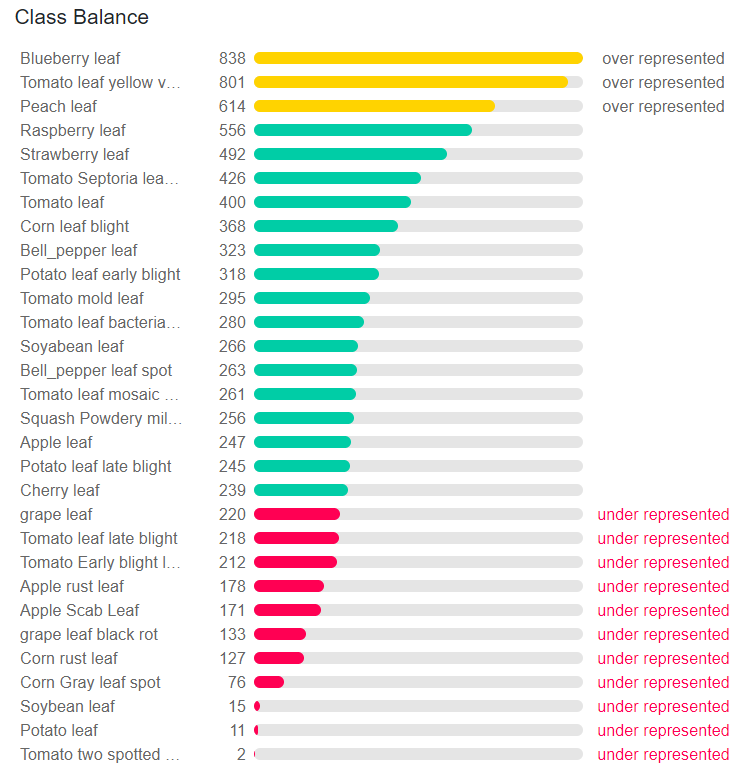

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

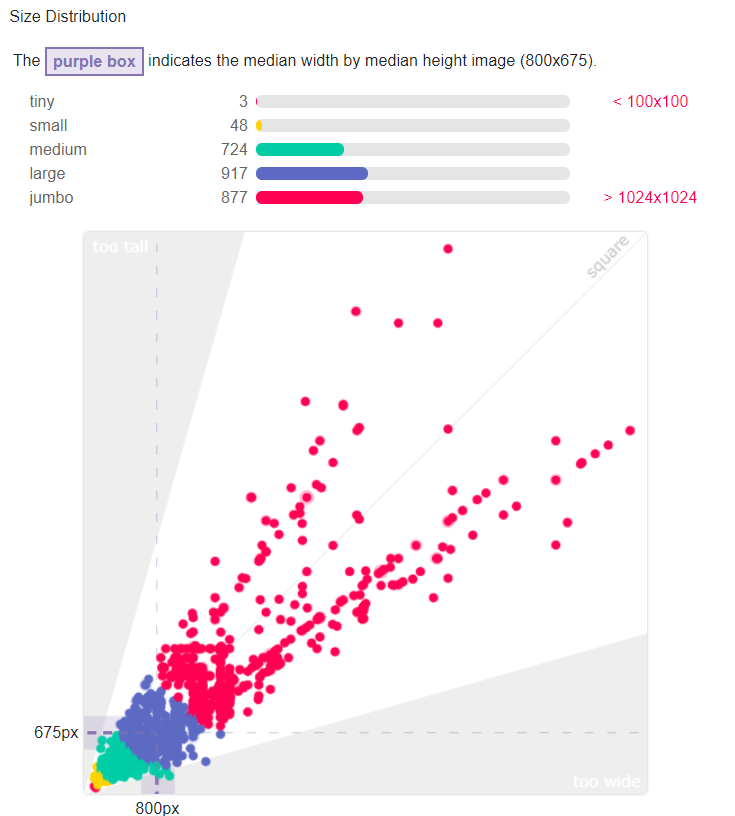

In [ ]:
#kullanacağımız modelin default hali
%cat /content/yolov5/models/yolov5l.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3,

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
print(num_classes)

30


#Finetuning: Yolov5l

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

#Train the model

In [ ]:

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 32 --epochs 200 --data '../data.yaml' --cfg ./models/custom_yolov5l.yaml --weights '' --name yolov5l_results  --cache

#Results

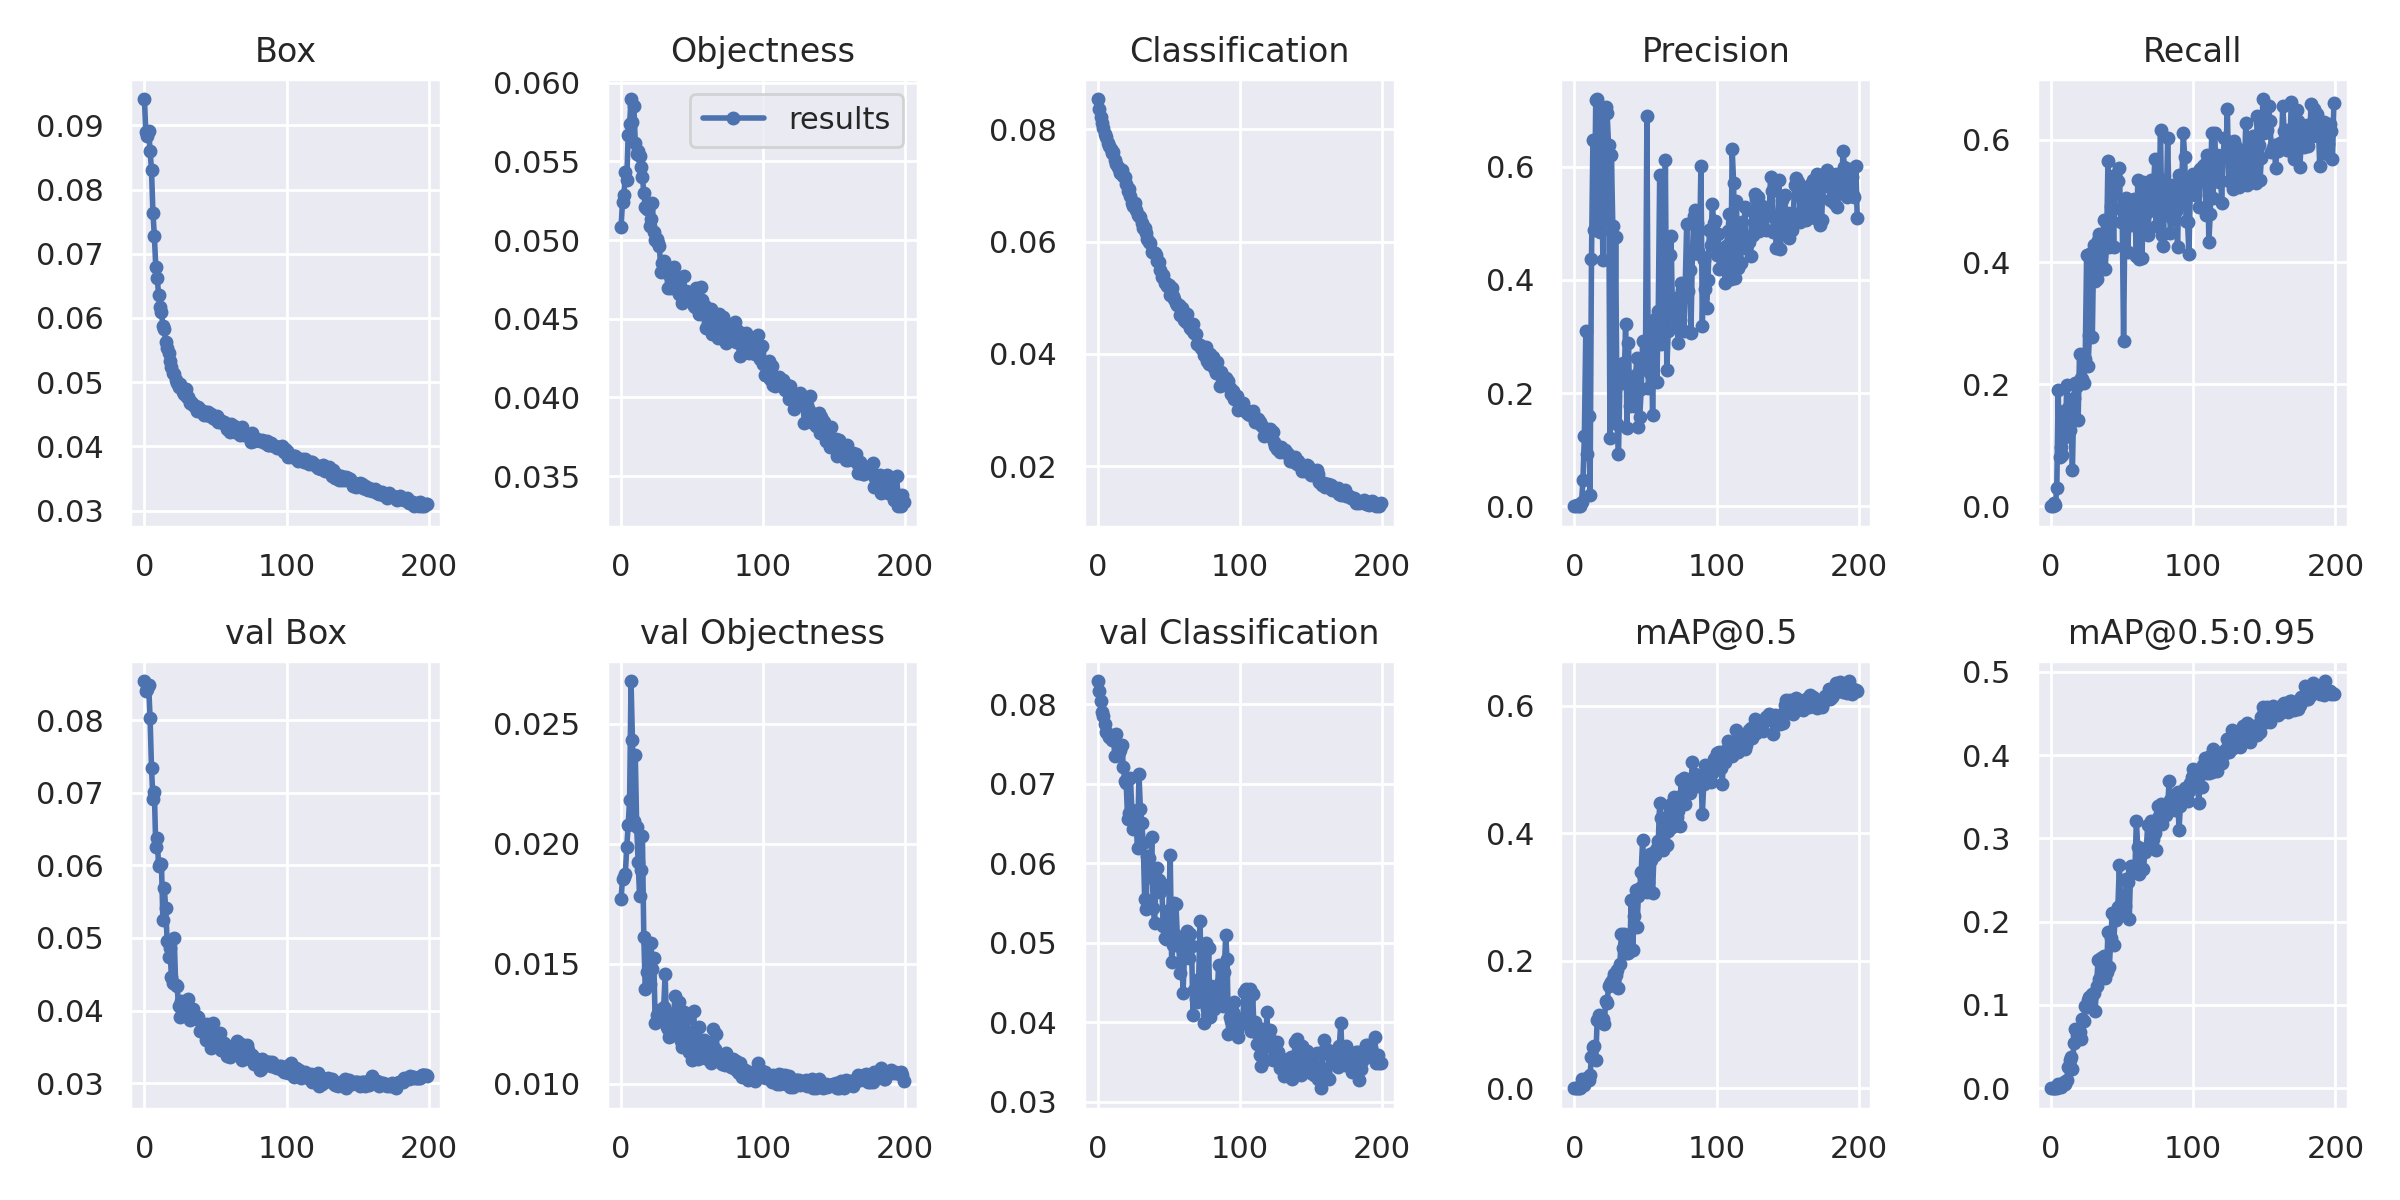

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5l_results/results.png', width=1000)  # view results.png

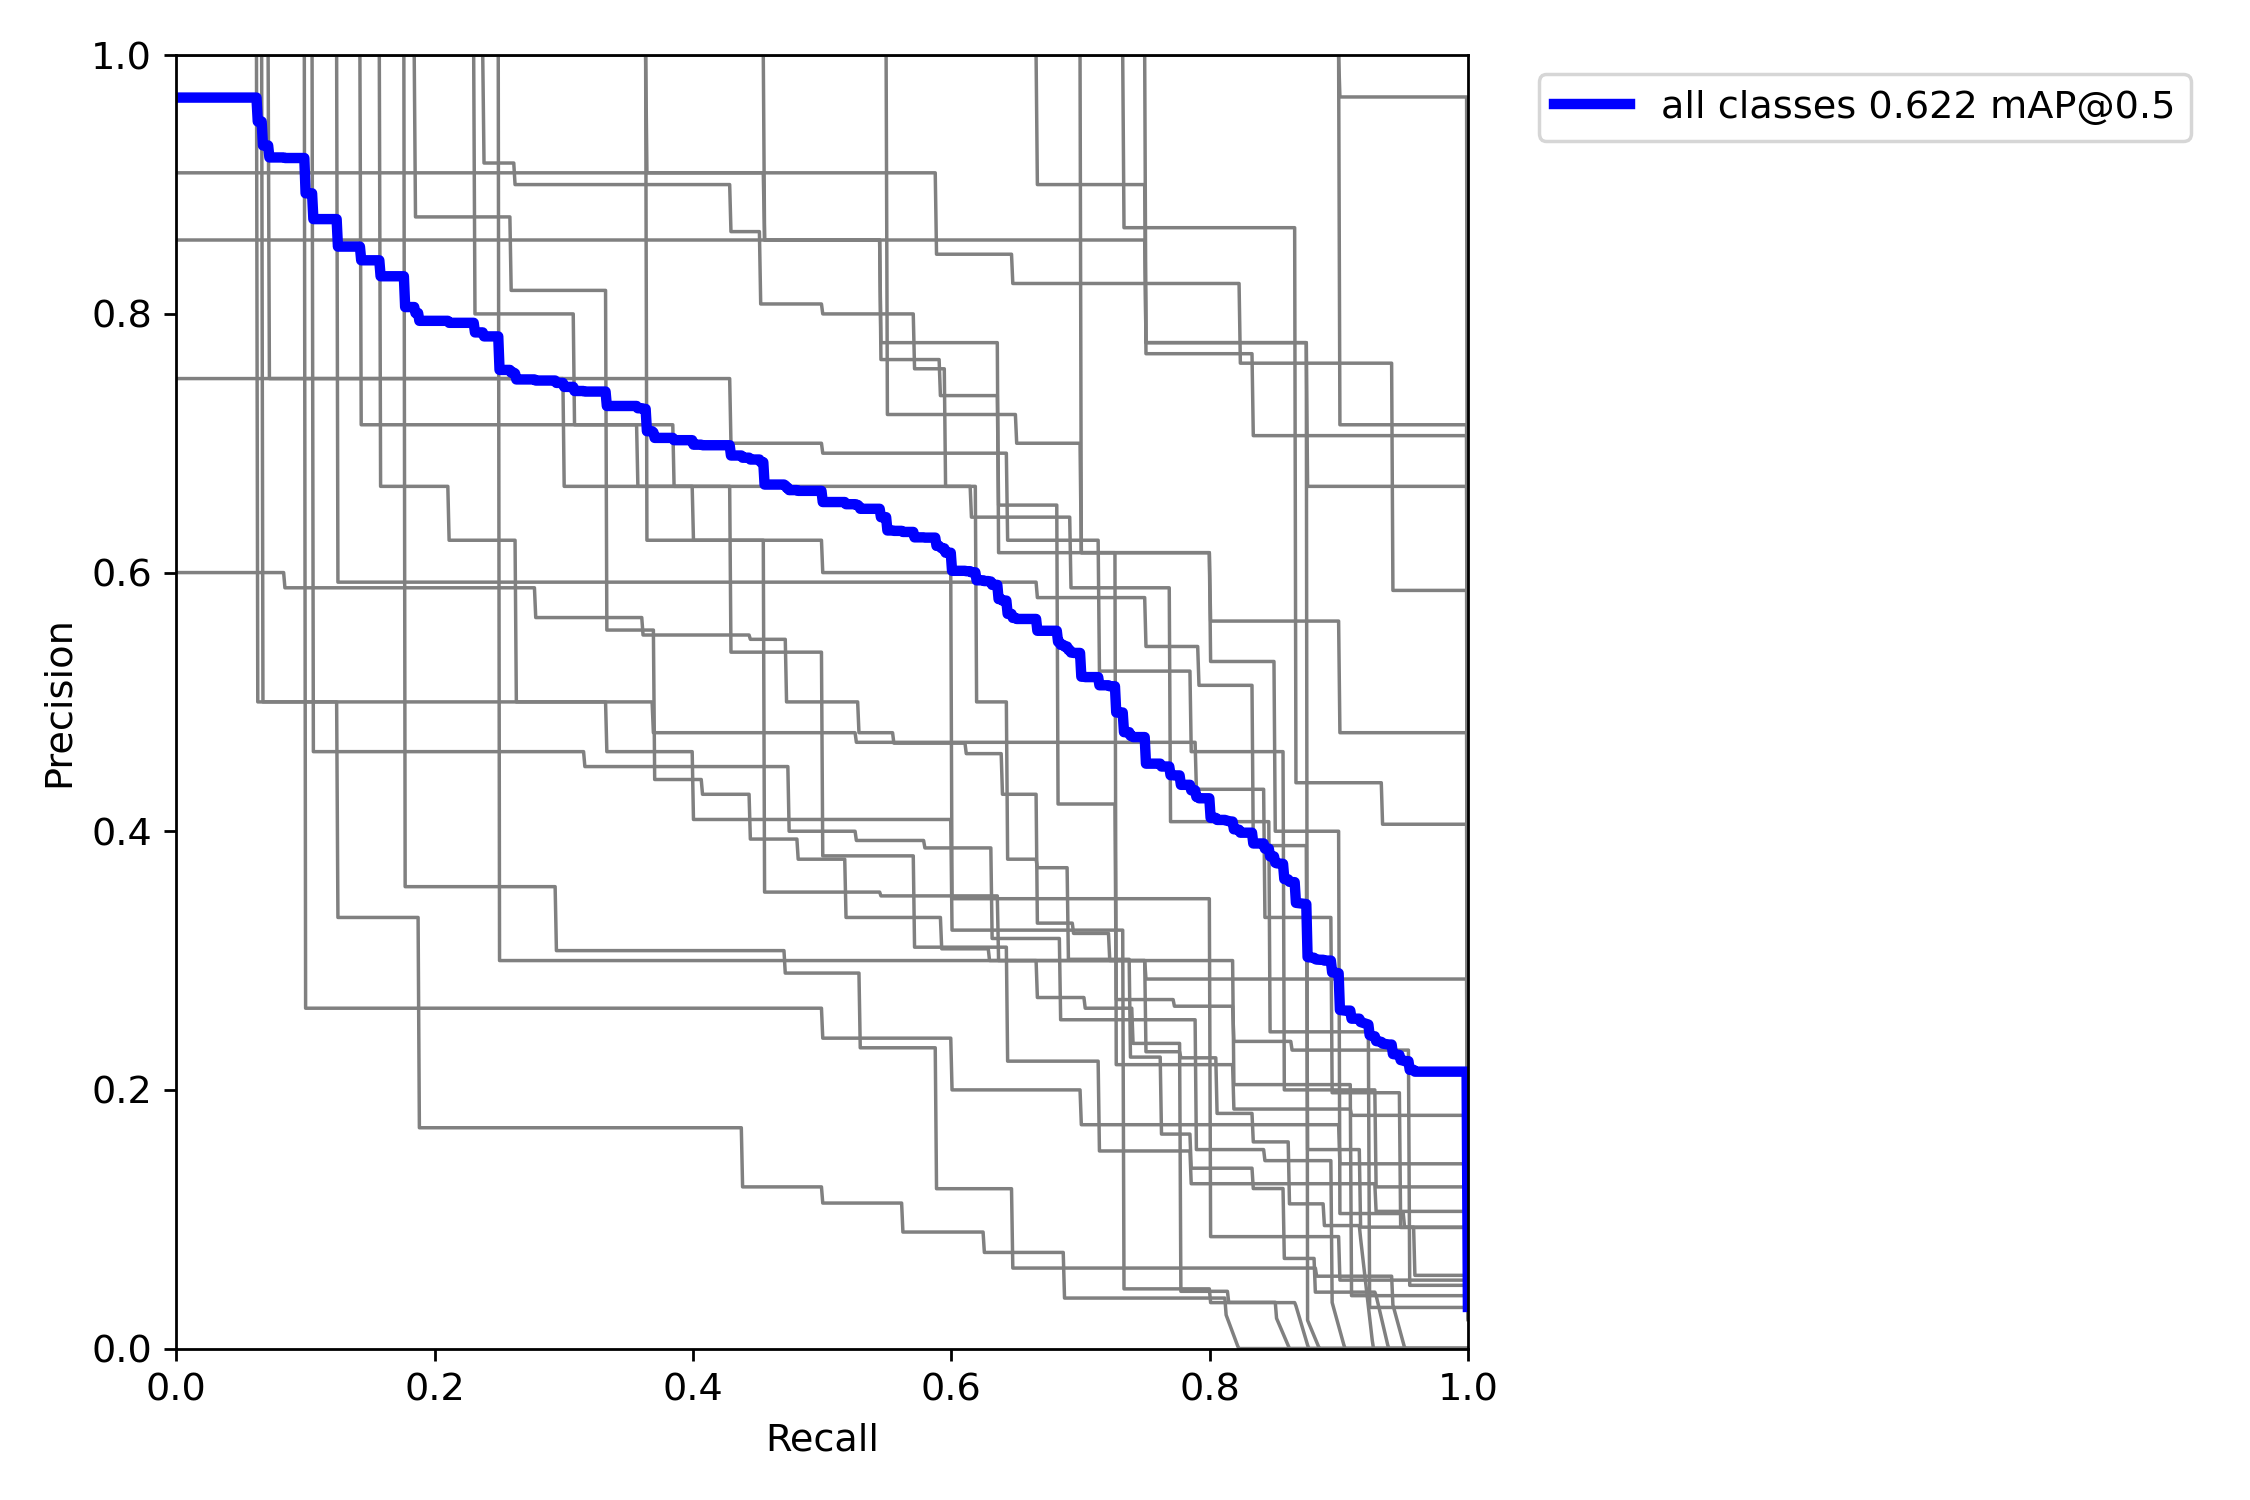

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5l_results/PR_curve.png', width=500)  # PR curve

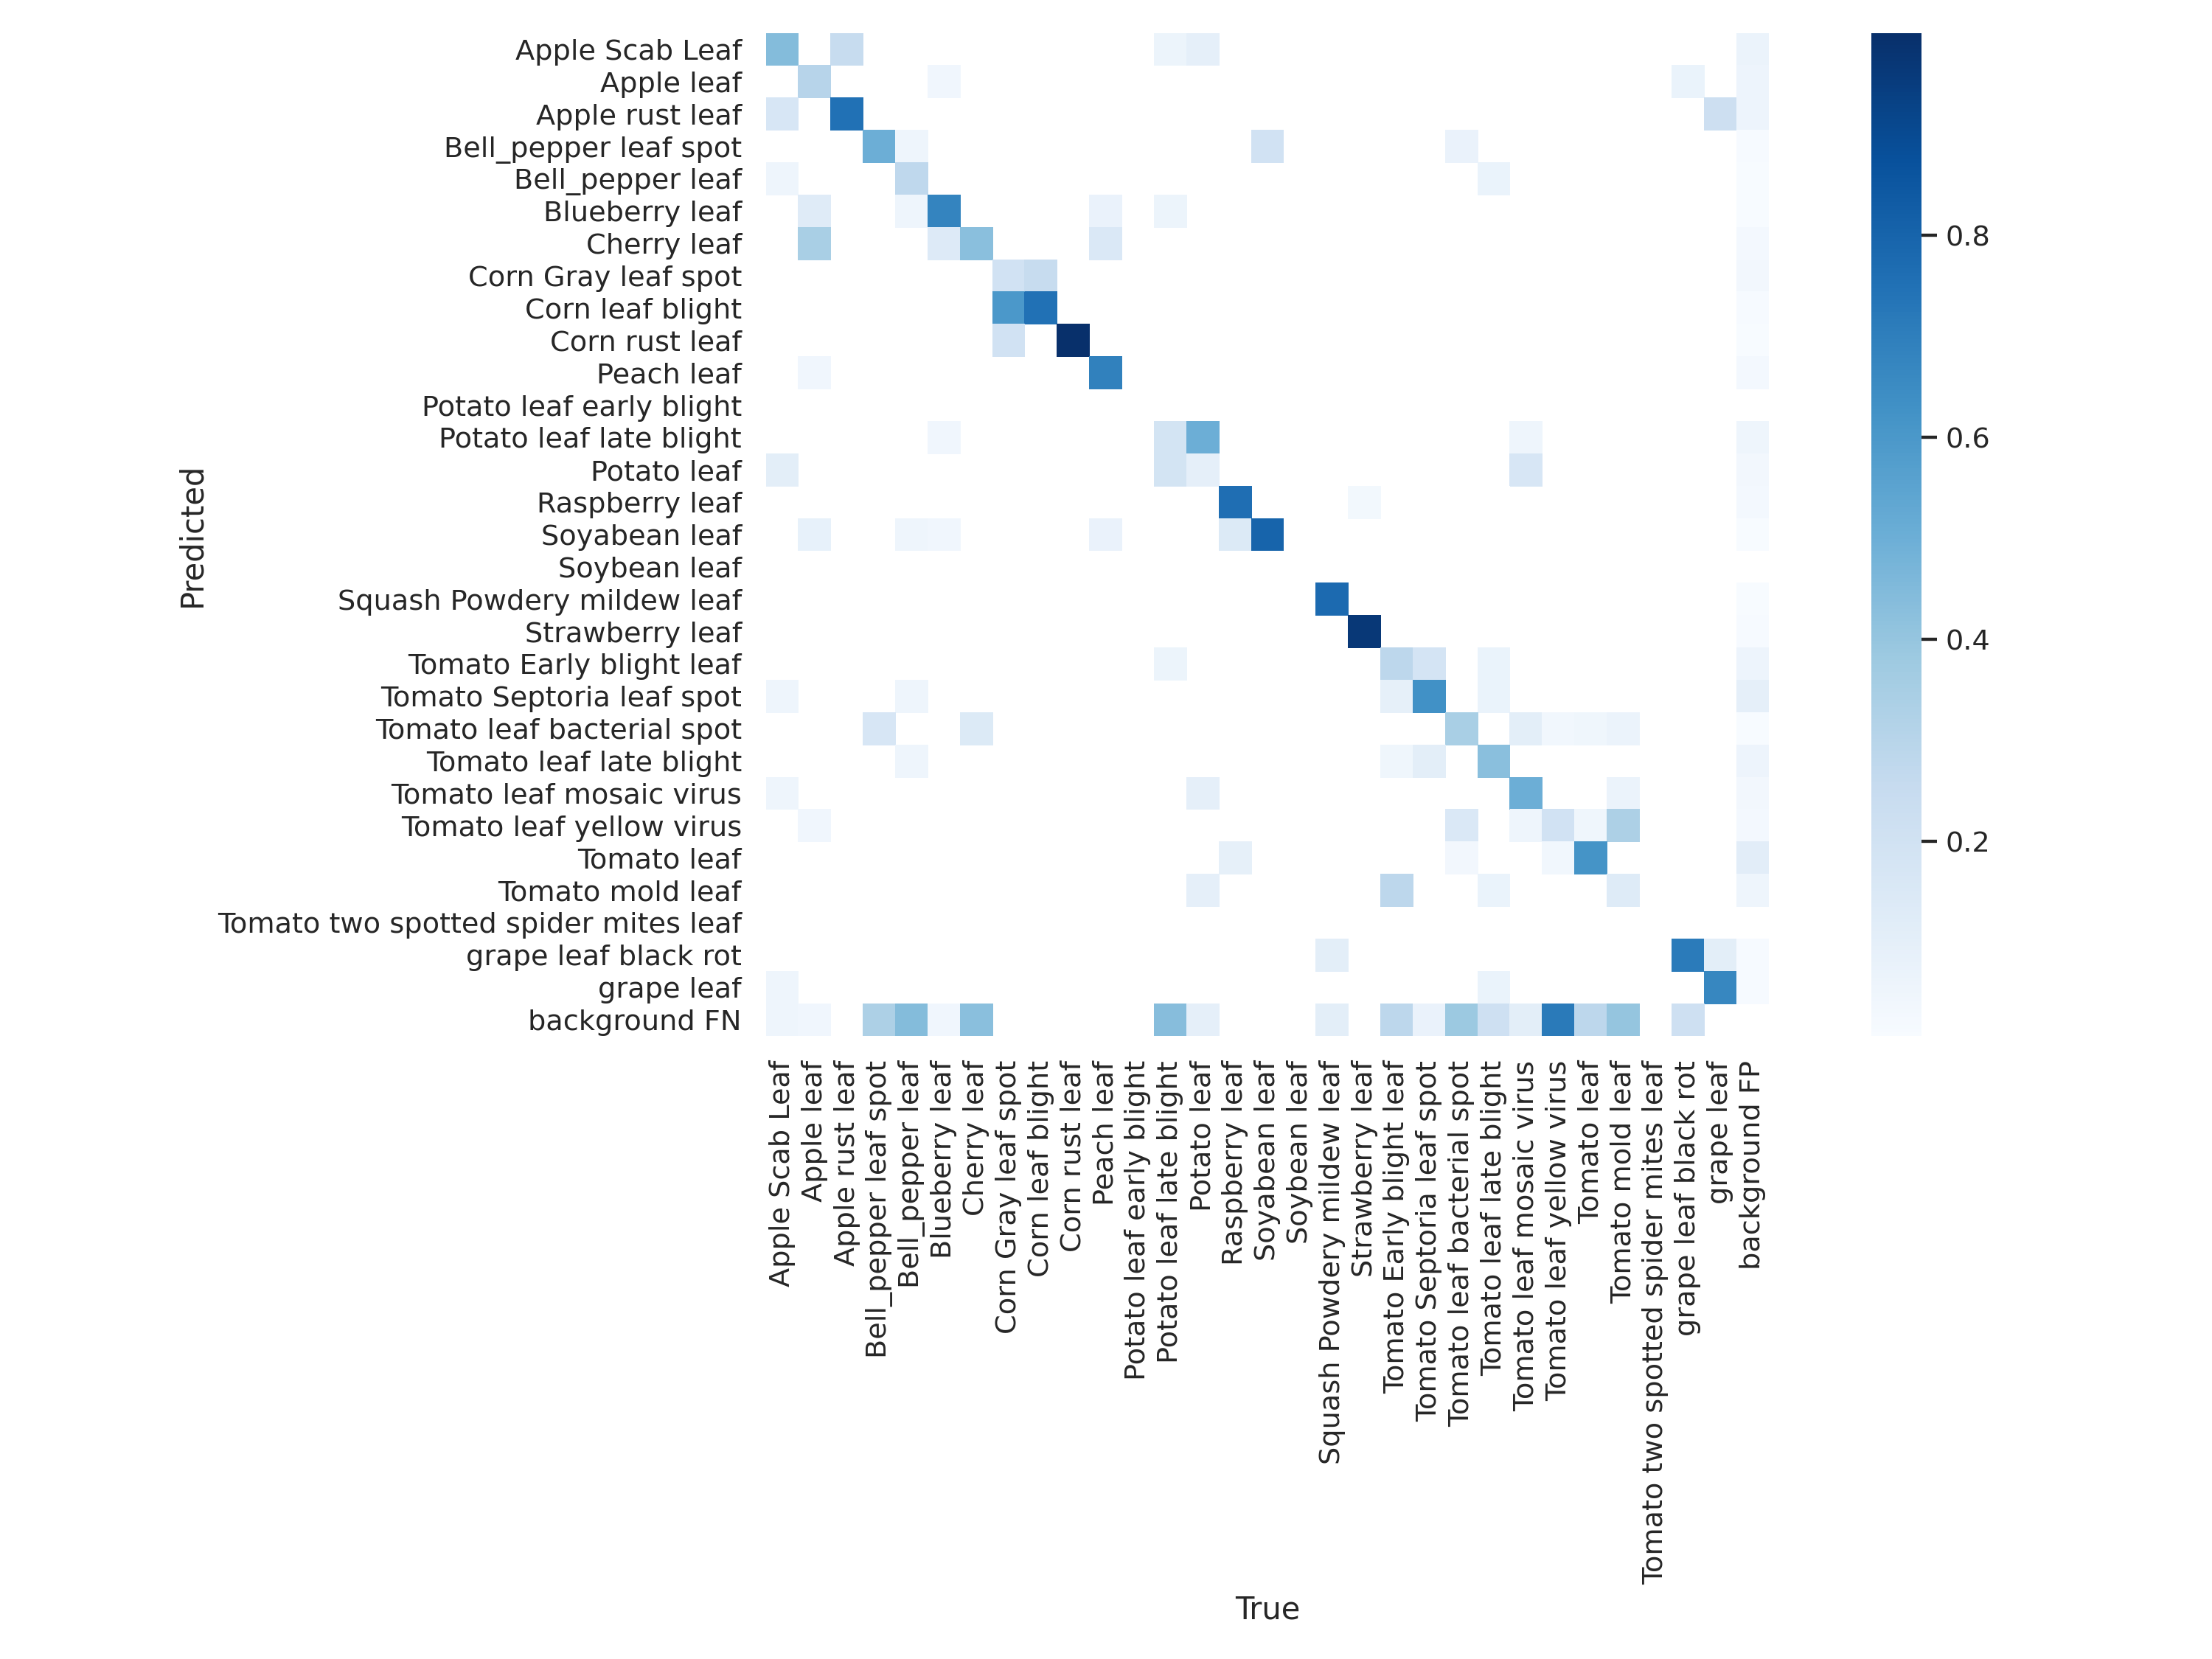

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5l_results/confusion_matrix.png', width=750)  # conf matrix

Ground Truths

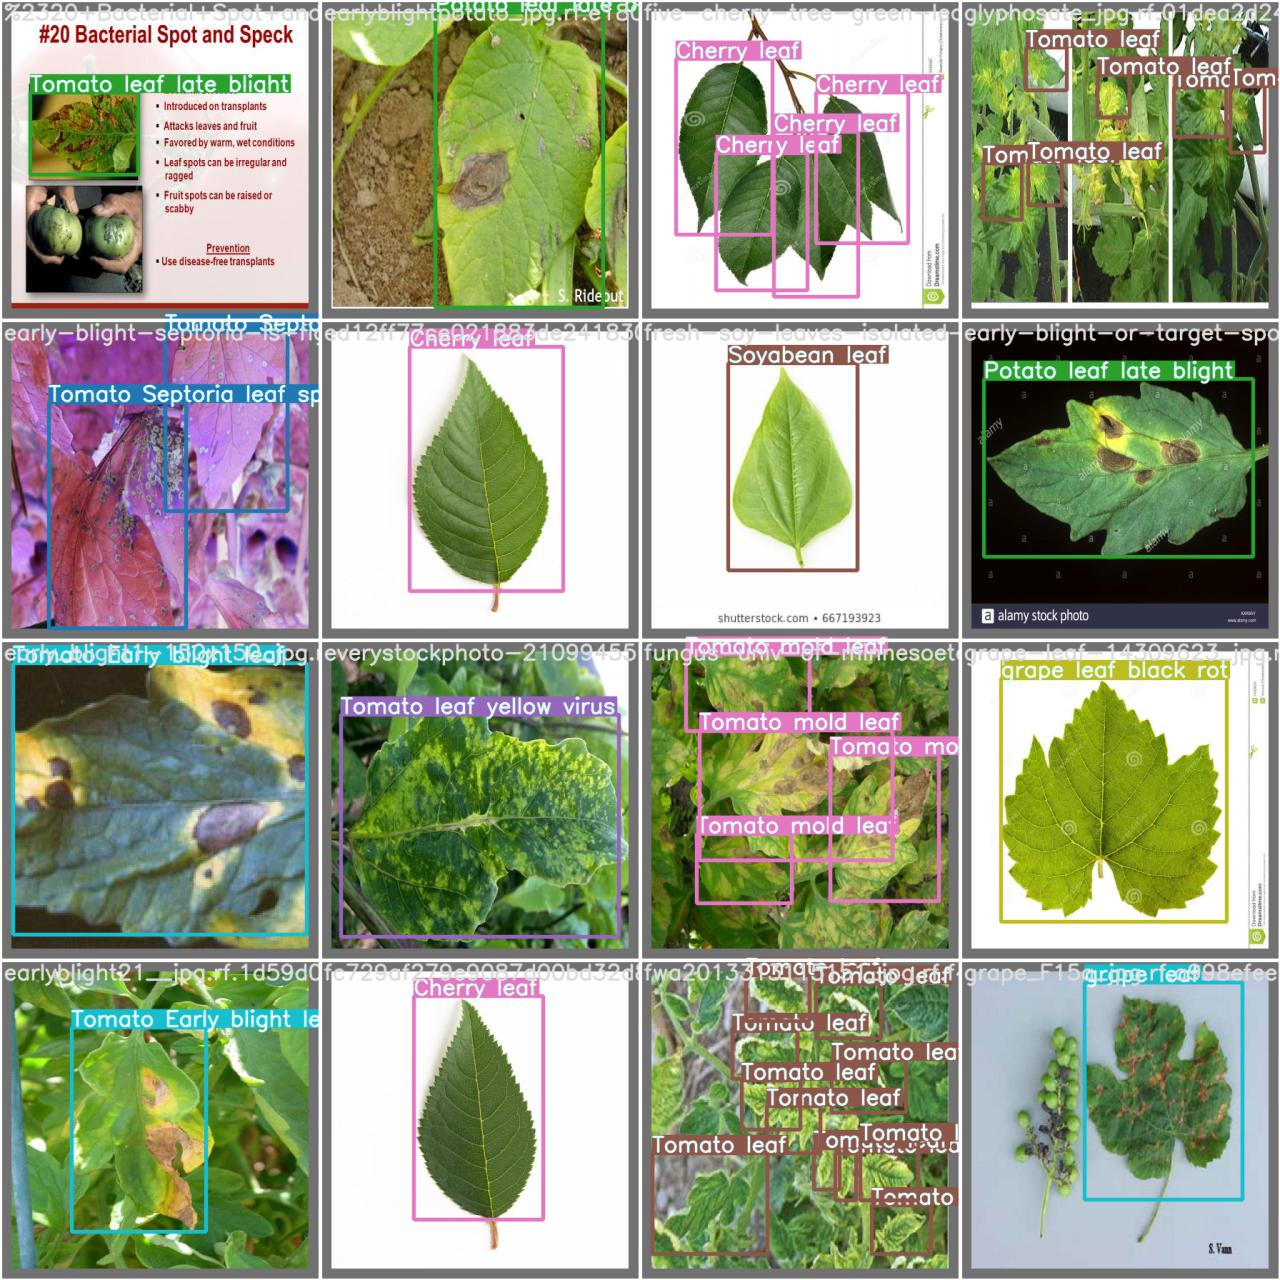

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5l_results/test_batch0_labels.jpg')  # conf matrix

Predicted Values

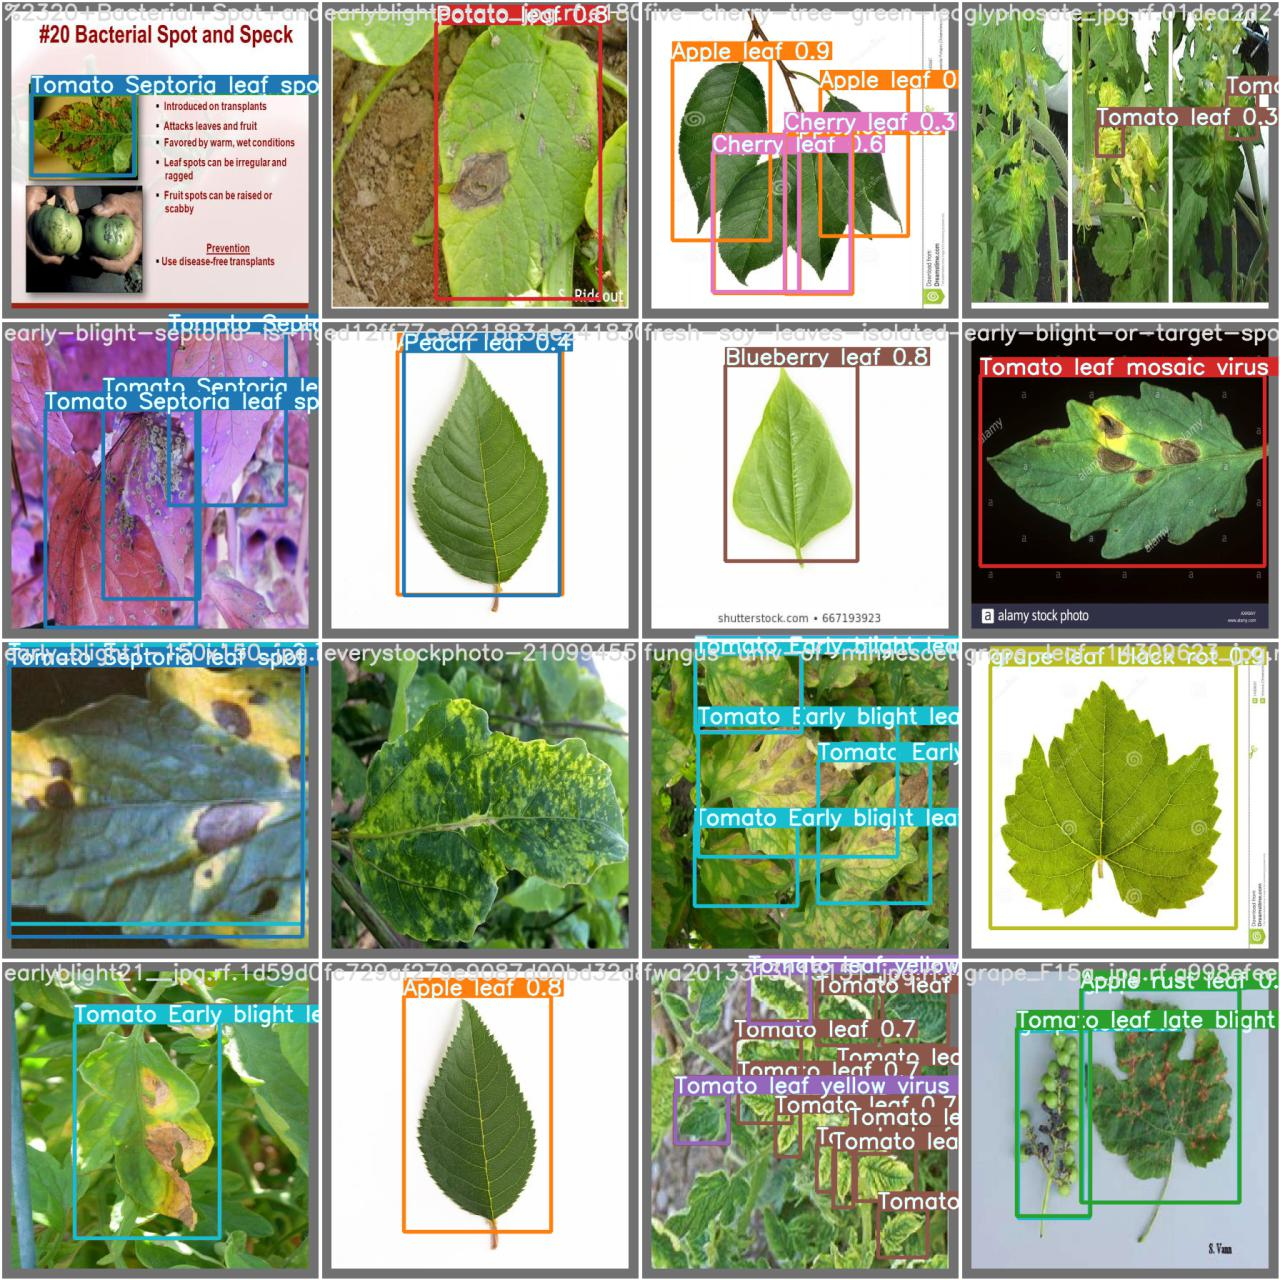

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5l_results/test_batch0_pred.jpg')  # conf matrix

#Save model
Save the pre-trained weights to the specified drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%cp /content/yolov5/runs/train/yolov5l_results/weights/best.pt /content/drive/MyDrive/ObjectDetection/yoloV5l/